e:\oosun\Documents\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7286012526096033

Classification Report:
               precision    recall  f1-score   support

           A       0.40      0.19      0.26        21
           B       0.53      0.43      0.47        54
           C       0.51      0.68      0.58        78
           D       0.59      0.47      0.52        83
           F       0.90      0.95      0.92       243

    accuracy                           0.73       479
   macro avg       0.59      0.54      0.55       479
weighted avg       0.72      0.73      0.72       479



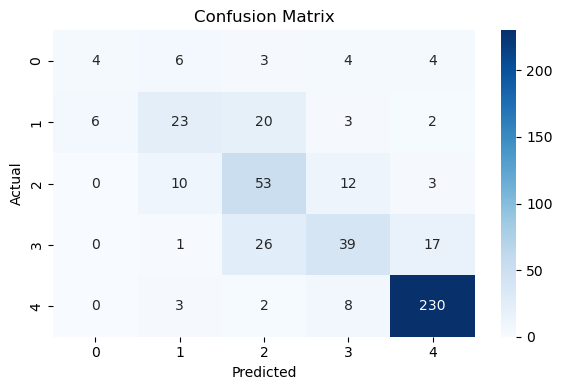

First 20 Predictions:


,Actual,Predicted,Match
0,4.000000,4.000000,True
1,4.000000,4.000000,True
2,4.000000,4.000000,True
3,4.000000,4.000000,True
4,2.000000,1.000000,False
5,3.000000,3.000000,True
6,2.000000,2.000000,True
7,4.000000,2.000000,False
8,4.000000,4.000000,True
9,3.000000,4.000000,False


Predicted Grade: C ,for given student input


C:\Users\oosun\AppData\Local\Temp\ipykernel_12328\3820173471.py:108: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')  # Cast numerics properly


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

#Step 1: Import CSVs
df_train = pd.read_csv('../data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["StudentID", "GradeClass", "GPA"])
y_train = df_train['GradeClass']

X_test = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y_test = df_test['GradeClass']

#Step 3: Feature sclaing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Step 4: Tune and train Logistic Regression model using GridSearchCV

#Define the model
ln = LogisticRegression(solver='lbfgs', max_iter=100)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],     
    'penalty': ['l2'],               
    'max_iter': [100, 200, 500]      
}
base_model = LogisticRegression(solver='lbfgs', multi_class='auto')
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

#Use best model found
ln = grid_search.best_estimator_

#Step 5: Save the model as pkl file in artifacts
with open("../artifacts/regression_model.pkl", "wb") as file:
    pickle.dump(ln, file)
with open("../artifacts/regression_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

#Setp 6: predictions using the test data
predictions = ln.predict(X_test_scaled)

#Step 7: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions, target_names=["A", "B", "C", "D", "F"]))

#Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 8: Show and save the prediction table
try:
    from IPython.display import display

    # Prepare DataFrame for display
    comparison_df = pd.DataFrame({"Actual": y_test.values,"Predicted": predictions})
    comparison_df["Match"] = comparison_df["Actual"] == comparison_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))

#Step 9: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual_GradeClass"] = y_test.values
comparison_df["Predicted_GradeClass"] = predictions
comparison_df.to_csv("../data/regression_prediction.csv", index=False)

#Prediction function for the given input test
def predict_student_grade(input_string):
    columns = ["Age", "Gender", "Ethnicity", "ParentalEducation", "StudyTimeWeekly", "Absences", "Tutoring", "ParentalSupport", "Extracurricular","Sports", "Music", "Volunteering"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Automatically remove the first value (StudentID) and last two values (GPA & GradeClass)
    input_data = input_data[1:-2] # Removes 1 from start and last 2 items

    # Create DataFrame from input
    df_input = pd.DataFrame([input_data], columns=columns)
    df_input = df_input.apply(pd.to_numeric, errors='ignore')  # Cast numerics properly

    # Scale input using the same scaler
    input_scaled = scaler.transform(df_input)

    # Predict using the loaded model
    prediction = ln.predict(input_scaled)
    
    #Mapping numeric class baack to the letter grade
    grade_map = {0: "A", 1: "B", 2: "C", 3: "D", 4: "F"}

    predicted_grade = grade_map[prediction[0]] 

    return predicted_grade

#Step 10: Example testing input from the csv file
student_input = "1015,18,1,0,1,11.197810636915708,9,1,2,0,0,0,0,2.396788117124796,3.0"

#Print predicted grade
print(f"Predicted Grade: {predict_student_grade(student_input)} ,for given student input")






